# Steam Reviews Classifier with BERT
Here I’ll try to show how BERT handles the classification of reviews in Steam. For the BERT part, I will use [xhlulu](https://www.kaggle.com/xhlulu) code.

In [1]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tokenization

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/steam-reviews-dataset/steam_reviews.csv


In [3]:
data = pd.read_csv('/kaggle/input/steam-reviews-dataset/steam_reviews.csv')
data.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
0,2019-02-10,2,4,578,False,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns
1,2019-02-10,0,0,184,False,Recommended,yes.,Expansion - Hearts of Iron IV: Man the Guns
2,2019-02-07,0,0,892,False,Recommended,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns
3,2018-06-14,126,1086,676,False,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight
4,2017-06-20,85,2139,612,False,Recommended,Disclaimer I survivor main. I play games for f...,Dead by Daylight


In [4]:
data.describe()

,funny,helpful,hour_played
count,4.348910e+05,434891.000000,434891.000000
mean,5.333024e+05,1.004114,364.130773
std,4.785640e+07,59.462935,545.961198
min,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000,62.000000
50%,0.000000e+00,0.000000,190.000000
75%,0.000000e+00,0.000000,450.000000
max,4.294967e+09,28171.000000,31962.000000


In [5]:
data.recommendation.value_counts()

Recommended        303593
Not Recommended    131298
Name: recommendation, dtype: int64

Most reviews are positive

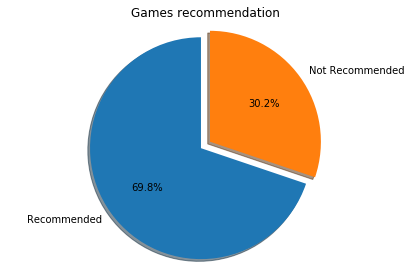

In [6]:
sizes = [data.recommendation.value_counts()[0], data.recommendation.value_counts()[1]]
labels = ['Recommended', 'Not Recommended']

explode = (0, 0.1)
fig1, ax1 = plt.subplots()
ax1.set_title('Games recommendation')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

ax1.axis('equal')  
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Number of reviews')

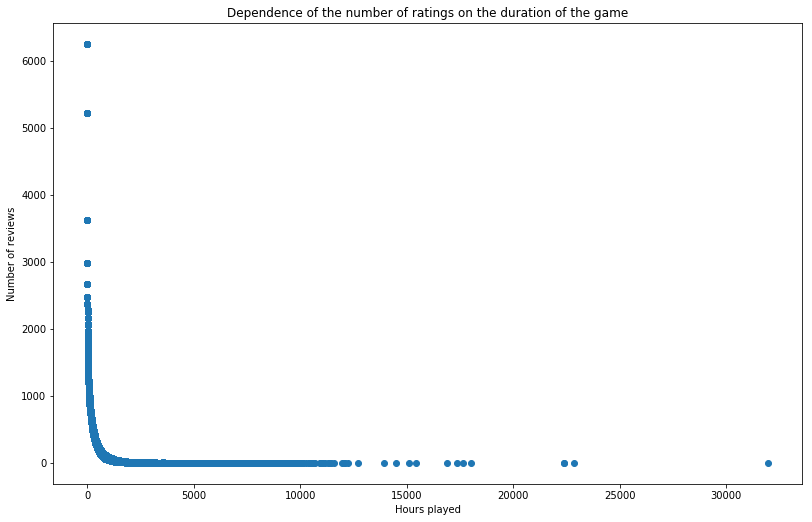

In [7]:
data['hour_played_reviews'] = data.groupby('hour_played')['hour_played'].transform('count')
x = data.hour_played
y = data['hour_played_reviews']
fig = plt.figure(figsize = (13,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.scatter(x,y)
ax.set_title('Dependence of the number of ratings on the duration of the game')
ax.set_xlabel('Hours played')
ax.set_ylabel('Number of reviews')

The graph looks ugly, but we can see here that a greater number of reviews are made by players who played only a few hours, and very few reviews where players played for really long.

In [8]:
top_reviewed_games = data.title.value_counts()
print('Top 10 reviewed games:\n\n{}'.format(data.title.value_counts()[:10]))

Top 10 reviewed games:

PLAYERUNKNOWN'S BATTLEGROUNDS                  145685
Grand Theft Auto V                              99956
Rust                                            71088
Rocket League®                                  67907
Dead by Daylight                                22221
MONSTER HUNTER: WORLD                           18412
ASTRONEER                                        2661
The Elder Scrolls V: Skyrim Special Edition      1473
RESIDENT EVIL 2 / BIOHAZARD RE:2                 1385
Sid Meier’s Civilization® VI                      522
Name: title, dtype: int64


Data contain reviews from Steam's best selling games as February 2019

In [9]:
data = data.assign(y = (data.recommendation == 'Recommended').astype(int))
data.head(3)

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,hour_played_reviews,y
0,2019-02-10,2,4,578,False,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns,171,1
1,2019-02-10,0,0,184,False,Recommended,yes.,Expansion - Hearts of Iron IV: Man the Guns,664,1
2,2019-02-07,0,0,892,False,Recommended,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns,85,1


In [10]:
print(len(data)/2)
data_cut = data[0:25000] # We will use just a small portion of data 
data_cut.tail(1)         # because BERT with a full data size will work for a very long time

217445.5


,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,hour_played_reviews,y
24999,2018-08-11,0,0,39,False,Recommended,Games good and Ive ran into no troubles concer...,MONSTER HUNTER: WORLD,1322,1


In [11]:
data_cut.review = [str(x) for x in data_cut.review.values] # So that there are no problems in the tokenizer

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [12]:
from sklearn.model_selection import train_test_split
X = data_cut.review
y = data_cut.y
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 42, test_size=0.50)
for each in [y_train, y_test]:
    print(f"y fraction = {each.mean():.4f}")

y fraction = 0.7669
y fraction = 0.7702


We check how identical we got the parts. If the difference is big, you need to try mixing the data with another method. However, now we have a very good ratio.

In [13]:
print('Train : {}, Test: {}'.format(len(X_train),len(X_test)))

Train : 12500, Test: 12500


In [14]:
#X_test = X_test[:-2] # if it's not equal
#y_test = y_test[:-2]
#X_train = X_train[:-1]
#y_train = y_train[:-1]
print('\n train X: {} \n train y: {} \n Val X: {} \n val y: {}'.format(len(X_train),len(y_train),len(X_test),len(y_test)))


 train X: 12500 
 train y: 12500 
 Val X: 12500 
 val y: 12500


In [15]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 1min 21s, sys: 7.25 s, total: 1min 29s
Wall time: 1min 31s


In [16]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [17]:
def bert_encode(input_text, tokenizer, max_len = 512):
    token_input = [] 
    mask_input = []
    seg_input = []
    
    for text in input_text:
        text = tokenizer.tokenize(text)
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)      
        token_input.append(tokens + [0]*pad_len)
        mask_input.append([1]*len(input_sequence) + [0]*pad_len)
        seg_input.append([0] * max_len)
        
    return np.array(token_input), np.array(mask_input), np.array(seg_input)

In [18]:
def build_model(bert_layer, max_len = 512):
    input_word_ids = Input(shape=(max_len, ),dtype = tf.int32,name = 'input_words_ids')
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    
    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [19]:
%%time
train_input = bert_encode(X_train.values, tokenizer, max_len=160)
test_input = bert_encode(X_test.values, tokenizer, max_len=160)
train_labels = y_train.values

CPU times: user 47.9 s, sys: 53.8 ms, total: 47.9 s
Wall time: 48 s


In [20]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words_ids (InputLayer)    [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_words_ids[0][0]            
                                                                 input_mask[0][0]             

In [21]:
%%time
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    batch_size=16
)

model.save('model.h5')

Train on 10000 samples, validate on 2500 samples
Epoch 1/3
10000/10000 [==============================] - 653s 65ms/sample - loss: 0.3586 - accuracy: 0.8392 - val_loss: 0.3073 - val_accuracy: 0.8624
Epoch 2/3
10000/10000 [==============================] - 613s 61ms/sample - loss: 0.2394 - accuracy: 0.9027 - val_loss: 0.2986 - val_accuracy: 0.8680
Epoch 3/3
10000/10000 [==============================] - 613s 61ms/sample - loss: 0.1675 - accuracy: 0.9360 - val_loss: 0.3115 - val_accuracy: 0.8672
CPU times: user 17min 57s, sys: 11min 57s, total: 29min 54s
Wall time: 31min 53s


In [22]:
prediction = model.predict(test_input)
preds = []
for x in prediction:
    preds.append(int(x.round()))

from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(preds, y_test.values))

Accuracy:  0.87592


Not bad for lazy model without data cleaning